# Pypi dependency

### Github Repository
A link to the assignment repository with all the relevant code is avaliable [here](https://github.com/MathiasDamsgaard/Comp_Social_Sci_Assigments.git), while the repository responsible for the webpage deployment can be found [here](https://github.com/MathiasDamsgaard/Comp_Social_Sci_Webpage).

### Contribution statement
We all helped each other with the different parts of the project. For choosing the topic and collecting the data we all helped and contributed equally. Later on, Anton took responsability for the network analysis, Andreas then stood for the textual analysis, and Mathias for the webpage and overall layout. Everyone still helped working on every part to properly agree on the final conclusions.

### Webpage
The webpage is built using Github pages and hugo. You can access the webpage through [this link](https://MathiasDamsgaard.github.io/Comp_Social_Sci_Webpage/), and a hosting of this repository's README on [this link](https://MathiasDamsgaard.github.io/Comp_Social_Sci_Assignments/).

## Motivation
This project works to investigate a network constructed of _python packages' dependencies_ on each other. This is based on the available packages on [python package index (pypi)](https://pypi.org/). Inspiration of this project idea comes from seeing an older dataset on [Netzschleuder](https://networks.skewed.de/net/python_dependency) made by Kevin Gullikson. His [original blogpost](https://kgullikson88.github.io/blog/pypi-analysis.html) is from 2016, and will therefore be used as a baseline for comparing the networks on a timescale.

We found it interesting to research how the package library in Python has evolved over the years and further investigate which packages seem to be the hubs of all other packages. Creating libraries is a big part of programming to help make functions easier to use across files and users, and thus we hope we also will gain insight into how these libraries potentially fall into different groups to see in which fields users most often create new libraries.
By also analysing the text available in README files, we hope to gain insight into how programmers formulate themselves when writing documentation for their code, and if it varies across different groups.

Hopefully will the end user experience a breath of fresh air when reading through our analysis. It is a different and not often seen type of network, so we would like it, if the user found our research interesting not only from a computer science point of view, but also from a social science angle. While the project is inspiried by an interest for the idea of how the libraries will link togehter, it provides more insight into the habits of programmers, and it is this idea that we hope the end user will also learn something about, while reading through our website.

#### Imports

In [16]:
from typing import List, Dict, Any, Tuple, Union, Optional, Callable
# Modules
import nest_asyncio
nest_asyncio.apply()
import json
from bs4 import BeautifulSoup
import re
import xmlrpc.client as xc
from tqdm import tqdm
import pickle
import aiohttp
import asyncio
import time
import networkx as nx
import matplotlib.pyplot as plt
import netwulf as wulf
import numpy as np
import math
import random
from community import community_louvain
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import bigrams as make_bigrams
from nltk.collocations import BigramCollocationFinder
from nltk.metrics.association import BigramAssocMeasures
from scipy import stats
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import wordcloud as wc
import ast

In [ ]:
image_folder = 'data/images/'
# Just a temporary folder to store the images before moving them to the webpage repository and then deleting them from here

## Data Acqusition

First we collect all avaliable packages on pypi's website through the use of an external client. We lower alle package names to streamline the process later on.

In [ ]:
# Set client to the PyPI XML-RPC server
client = xc.ServerProxy('http://pypi.python.org/pypi')

# Get a list of all the packages
pypi_packages = client.list_packages()

# lowercase all the package names
pypi_packages = [package.lower() for package in pypi_packages]

# Save the list of packages
with open("data/packages.pkl", "wb") as f:
    pickle.dump(pypi_packages, f)

We then define a function that will check the website for a link to its Github repository, where it is expected it will be under a certian class that is located in the left column. As it is a link to a website it will have an a-tag followed by a hyperref, so we collect all these and through regex collect any and all github links. If we find more than one link, we assume the correct one to be the shortest one, which is presumptuous, but after looking through a larger handfull it is the method we found to be the most successful.

In [3]:
async def get_github_link(packages: list, semaphore: asyncio.Semaphore) -> list:
    """
    Function that takes a list of python packages and returns a list of tuples with the package name, the link to the PyPI page and the link to the GitHub page.
    
    packages: list
        List of python packages to search for.
        
    semaphore: asyncio.Semaphore
        Semaphore to limit the number of concurrent tasks.
        
    return: list
        List of tuples with the package name, the link to the PyPI page and the link to the GitHub page.
    """
    
    all_links = []
    async with semaphore, aiohttp.ClientSession() as session:
        for i, package in enumerate(packages):
            # The link to the python package
            LINK = f"https://pypi.org/project/{package}/"
            
            # Get the HTML content of the page
            try:
                async with session.get(LINK) as r:
                    if r.status != 200:
                        print(f"Request failed for {package, i}: {r.status}")
                        continue
                    content = await r.text()
            except Exception as e:
                print(f"Request failed for {package, i}: {str(e)}")
                continue
            
            # Parse the HTML content of the page
            soup = BeautifulSoup(content)
            
            # Get sidebar with links
            sidebar = soup.find("div", {"class": "vertical-tabs__tabs"})
            
            # Get all the links in the sidebar
            references = [link.get("href") for link in sidebar.find_all("a")]
            
            # Join into one string to regex in
            reference_text = " ".join([reference for reference in references if reference is not None])
            
            # Find the first link that contains the word "github.com"
            github_links = []
            for link in re.finditer(r"github\.com(/\w*|/\W|[-]\w*|[-]\W*)*", reference_text):
                if link.group() != "github.com/" and link.group() != "github.com":
                    github_links.append(link.group())
            
            # If there are no links, append None
            if len(github_links) == 0:
                github_link = None
            
            # If there's several take the shortest and alert the user
            elif len(github_links) > 1:
                # print(f"Several GitHub links found for {package, i}: {github_links}")
                github_link = min(github_links, key=len)
            
            # If there is just one link, take that out of the list
            elif len(github_links) == 1:
                github_link = github_links[0]
            
            # Else alert the user no githublink is found
            else:
                print(f"No GitHub link found for {package}")
                github_link = None
            
            # Append the triplet to the list
            all_links.append((package, LINK, github_link))
            
            # Sleep for a short period to avoid hitting rate limits
            await asyncio.sleep(0.1)
    
    return all_links

We then collect the links and clean up the following list to only include tuples were the github link exists.

In [ ]:
# Load packages
with open("data/packages.pkl", "rb") as f:
    pypi_packages = pickle.load(f)

# Create an event loop
loop = asyncio.get_event_loop()

# Create a semaphore
semaphore = asyncio.Semaphore(500)  # Adjust this value as needed

# Create a list to hold the tasks
tasks = []
chunk_size = 80

# For each chunk of packages
for chunk in [pypi_packages[i:i+chunk_size] for i in range(0, len(pypi_packages), chunk_size)]:
    # Create a task for the function and add it to the list
    task = asyncio.ensure_future(get_github_link(chunk, semaphore))
    tasks.append(task)

# Run all the tasks concurrently
all_links = loop.run_until_complete(asyncio.gather(*tasks))

# Flatten the list of lists into a single list
all_links = [link for sublist in all_links for link in sublist]

# Clean the list of None links
all_links = [(p, l, g) for p, l, g in all_links if g is not None]

# Save the list of links
with open("data/all_links_github.json", "w") as f:
    json.dump(all_links, f)

In [18]:
with open("data/packages.pkl", "rb") as f:
    pypi_packages = pickle.load(f)
print("Number of packages on pypi:", len(pypi_packages))

with open('data/all_links_github.json', 'r') as f:
    data_clean = json.load(f)
print("Number of packages to successfully get the github link from:", len(data_clean))

Number of packages on pypi: 533827
Number of packages to successfully get the github link from: 347955


The number of packages left drastically shrinks from the inital 530k+ to almost 350k. As one would normally assume public code like packages to be well documented, these do come in have sizes, where small packages only by only a handfull of people within a certain area might not put documentation up online as that is available internally. It is also possible that it wasn't every single package that had the link to the repository in the same way as the majority of packages, and we thereby lost some due to needing to make some choices on how to webscrape the data.

Following this, we then have to collect the information of off the Github repository. We want to collect both any readme file and the dependencies the package has. This is done based on another assumption, where we found out after investigating several repositories that the content files on a repo has it own URL structure of the format _https://raw.githubusercontent.com/brand-name/file-name_. Therefore, we replace the github.com with the raw URL, and just try different combinations of branch and files names. These combinations are chosen based on the results we found on different naming conventions we could find on different small and big repositories including numpy, pandas, matplotlib and pytorch. A branch was either named _main_ or _master_ and the README files ended with .md, .rst or .txt. The dependencies had a naming convention of one of the following:
* requirements-dev.txt
* dev-requiremtns.txt
* environment.yml
* pyproject.toml
* requirements.txt

If none of the combinations were successful for the dependencies we discarded the package, as we then couldn't link it properly in the network. However, if it was only the README file we couldn't find, we stil kept the package for the network analysis and would later drop for the textual analysis. We did this to stay as true to the network as possible.

In [5]:
async def node_creator(packages: list, semaphore: asyncio.Semaphore) -> list:
    """
    Function that takes a list of python packages and returns a list of nodes with the package name, readme text, and requirements text.
    
    packages: list
        List of python packages to search for.
        
    semaphore: asyncio.Semaphore
        Semaphore to limit the number of concurrent tasks.
        
    return: list
        List of nodes with the package name, readme text, and requirements text.
    """

        # For each package go to the GitHub page and get the readme.text if theres a README.md
    async def get_readme_text(session, github_link: str) -> list:
        """
        Function that takes a GitHub link and returns the text of the README.md file.
        
        github_link: str
            Link to the GitHub page.
            
        return: str
            Text of the README.md file.
        """

        # If there's no link, return None
        if github_link is None:
            return None
        
        readme_file_extensions = ['README.md', 'README.rst', 'README.txt']

        for extension in readme_file_extensions:
            try:
                async with session.get(f"{github_link}/main/{extension}") as response:
                    if response.status == 200:
                        readme_text = await response.text(errors='ignore')
                        break  # Exit the loop if the readme file is found
                async with session.get(f"{github_link}/master/{extension}") as response:
                    if response.status == 200:
                        readme_text = await response.text(errors='ignore')
                        break  # Exit the loop if the readme file is found
            except Exception as e:
                print(e)
                return None

        
        try:
            readme_text = BeautifulSoup(readme_text, "html.parser")
        except:
            return None

        # Clean the text using regex
        readme_text = re.sub(r"<.*?>", "", readme_text.text)    # Remove HTML tags
        readme_text = re.sub(r'```.*?```', '', readme_text, flags=re.DOTALL)   # Remove code blocks
        readme_text = re.sub(r"http.*", "", readme_text)    # Remove links which start with http
        readme_text = re.sub(r"/.*|./.*|../.*", "", readme_text)    # Remove links to files in the repository which start with / or ./ or ../
        readme_text = re.sub(r"\n", " ", readme_text)    # Convert /n to space
        readme_text = readme_text.lower()    # Make all text lowercase
        readme_text = re.sub(r"[^a-z0-9-_ ]", "", readme_text)    # Only keep Alphanumeric characters and - and _
        readme_text = re.sub(r" +", " ", readme_text)    # Remove multiple spaces
        readme_text = [line for line in readme_text.split(" ") if line != ""]    # Remove empty strings

        return readme_text


    async def get_requirements_text(session, github_link):
        """
        Function that takes a GitHub link and returns the text of the requirements.txt file.
        
        github_link: str
            Link to the GitHub page.
            
        return: str
            Text of the requirements.txt file.
    """


        # If there's no link, return None
        if github_link is None:
            return None
        
        txt_bool = True
        pyproject_bool = False

        requirements_file_extensions = ['requirements-dev.txt', 'dev-requirements.txt', 'environment.yml', 'pyproject.toml', 'requirements.txt']

        requirements_text = None

        for extension in requirements_file_extensions:
            try:
                async with session.get(f"{github_link}/main/{extension}") as response:
                    if response.status == 200:
                        requirements_text = await response.text(errors='ignore')
                        break  # Exit the loop if the requirements file is found
                async with session.get(f"{github_link}/master/{extension}") as response:
                    if response.status == 200:
                        requirements_text = await response.text(errors='ignore')
                        break  # Exit the loop if the requirements file is found
            except Exception as e:
                print(e)
                return None

        if requirements_text is None:
            return None


        if extension[-4:] == '.txt':
            txt_bool = True
            pyproject_bool = False
        elif extension[-4:] == '.yml':
            txt_bool = False
            pyproject_bool = False
        elif extension[-5:] == '.toml':
            txt_bool = False
            pyproject_bool = True

        # Clean the text using regex
        cleaning_reg = r"=.*|>.*|~.*|\[.*\]|;.*|<.*|!.*"

        if txt_bool:
            # Example: 
                # versioneer[toml]
                # cython~=3.0.5
                # meson[ninja]==1.2.1
                # meson-python==0.13.1
                # pytest-qt>=4.2.0
            # We only want the package name and not the version or extras
            requirements_text = re.sub(r"\[.*\]", "", requirements_text)
            requirements_text = re.sub(r"#.*", "", requirements_text)        # Remove comments
            requirements_text = re.sub(f"{cleaning_reg}", "", requirements_text)        # Clean the text using regex
            requirements_text = requirements_text.lower()        # lower case
            requirements_text = requirements_text.split("\n")        # Convert to list
            requirements_text = [requirement.strip() for requirement in requirements_text]        # Remove trailing spaces
            requirements_text = [requirement for requirement in requirements_text if requirement != ""]        # Remove empty strings

        elif pyproject_bool:
            # Example:
                # [project]
                # name = "pydata-sphinx-theme"
                # description = "Bootstrap-based Sphinx theme from the PyData community"
                # requires-python = ">=3.9"
                # dependencies = [
                # "Babel",
                # "pygments>=2.7",
                # ]
                # [project.optional-dependencies]
                # doc = [
                # "numpydoc",
                # "linkify-it-py", # for link shortening
                # ]

            requirements_text = re.sub(r"#.*", "", requirements_text)         # Remove comments
            dependencies = re.findall(r'dependencies = \[\n(.*?)\n\]', requirements_text, re.DOTALL)
            optional_dependencies = re.findall(r'optional-dependencies\]\n.*? = \[\n(.*?)\n\]', requirements_text, re.DOTALL)
            if len(dependencies) == 0 and len(optional_dependencies) == 0:
                return None
            if len(dependencies) == 0:
                dependencies = [""]
            if len(optional_dependencies) == 0:
                optional_dependencies = [""]

            # The names are either in '' or in ""
            dependencies = re.findall(r'".*?"', dependencies[0]) + re.findall(r"'.*?'", dependencies[0])
            optional_dependencies = re.findall(r'".*?"', optional_dependencies[0]) + re.findall(r"'.*?'", optional_dependencies[0])
            requirements_text = dependencies + optional_dependencies
            requirements_text = [requirement[1:-1] for requirement in requirements_text]         # Remove double quotes
            requirements_text = [re.sub(f"{cleaning_reg}", "", requirement) for requirement in requirements_text]         # Clean the text using regex
            requirements_text = [requirement.lower() for requirement in requirements_text]         # lower case
            requirements_text = [requirement.strip() for requirement in requirements_text]        # Remove trailing spaces
            requirements_text = [requirement for requirement in requirements_text if requirement != ""]         # Remove empty strings

        else:
            # Example:
                # name: myenv
                # channels:
                #   - defaults
                # dependencies:
                #   - numpy
                #   - pip
                #   - pip:
                #     - matplotlib
            
            requirements_text = re.sub(r"#.*", "", requirements_text)        # Remove comments
            requirements_text = re.findall(r"- .*", requirements_text)        # Only get the dependencies which start with '- '
            requirements_text = [re.sub(f"{cleaning_reg}", "", requirement) for requirement in requirements_text]        # Clean the text using regex
            requirements_text = [requirement.lower() for requirement in requirements_text]        # lower case
            requirements_text = [requirement[2:] for requirement in requirements_text]        # Convert to list
            requirements_text = [requirement.strip() for requirement in requirements_text]        # Remove trailing spaces
            requirements_text = [requirement for requirement in requirements_text if requirement != ""]        # Remove empty strings

            
        return requirements_text

    async with aiohttp.ClientSession('http://raw.githubusercontent.com/') as session:
        nodes = []
        for i, package in enumerate(packages):
            try:
                # The link to the python package
                package_name, _, github_url = package
                github_url = github_url.replace("github.com", "")

                async with semaphore:
                    readme_text = await get_readme_text(session, github_url)
                    requirements_text = await get_requirements_text(session, github_url)
                # Append the node to the list
                nodes.append((package_name, readme_text, requirements_text))
            except Exception as e:
                print(f"Failed to get node for {package_name, i}: {str(e)}")
                continue
    
    return nodes


In [4]:
# Example to show how a node gets generated
package_to_find = "numpy"

# Load clean data
with open('data/all_links_github.json', 'r') as f:
    data = json.load(f)

semaphore = asyncio.Semaphore(500)

# Test the function
for package in data:
    if package[0] == package_to_find:
        test_data = package
        break

# Create an event loop
loop = asyncio.get_event_loop()

# Create a list to hold the tasks
tasks = []

# Create a task for the function and add it to the list
task = asyncio.ensure_future(node_creator([test_data], semaphore))

# Run all the tasks concurrently
node = loop.run_until_complete(task)

print(node)

[('numpy', ['powered', 'by', 'numfocus', 'pypi', 'downloads', 'conda', 'downloads', 'stack', 'overflow', 'nature', 'paper', 'openssf', 'scorecard', 'numpy', 'is', 'the', 'fundamental', 'package', 'for', 'scientific', 'computing', 'with', 'python', '-', 'website', '-', 'documentation', '-', 'mailing', 'list', '-', 'source', 'code', '-', 'contributing', '-', 'bug', 'reports', '-', 'report', 'a', 'security', 'vulnerability', 'it', 'provides', '-', 'a', 'powerful', 'n-dimensional', 'array', 'object', '-', 'sophisticated', 'broadcasting', 'functions', '-', 'tools', 'for', 'integrating', '-', 'useful', 'linear', 'algebra', 'fourier', 'transform', 'and', 'random', 'number', 'capabilities', 'testing', 'numpy', 'requires', 'pytest', 'and', 'hypothesis', 'tests', 'can', 'then', 'be', 'run', 'after', 'installation', 'with', 'python', '-c', 'import', 'numpy', 'sys', 'sysexitnumpytest', 'is', 'false', 'code', 'of', 'conduct', '----------------------', 'numpy', 'is', 'a', 'community-driven', 'open',

In [ ]:
from tqdm.asyncio import tqdm_asyncio
# Run the function with asyncio to get all the nodes

# Function to divide a list into chunks
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

async def process_chunks(data, semaphore):
    nodes = []
    for chunk in chunks(data, 1):
        task = asyncio.ensure_future(node_creator(chunk, semaphore))
        nodes.append(task)
    # Run all tasks concurrently
    nodes = await asyncio.gather(*nodes)
    return nodes

async def main():
    # Create a semaphore with a limit of 50 concurrent tasks
    semaphore = asyncio.Semaphore(50)
    
    # Process data in chunks
    nodes = await process_chunks(data, semaphore)
    
    # Flatten the list of lists into a single list
    nodes = [node for sublist in nodes for node in sublist]

    # Save the list to a json file
    with open("data/nodes.json", "w") as f:
        json.dump(nodes, f)

# Assuming you have an event loop already created
loop = asyncio.get_event_loop()
# Run the main coroutine
loop.run_until_complete(main())

## Data Preprocessing & Description
We make the edge list by first getting the names of all the packages in the network. This is used as a reference point, for whether a requirement to a package should be added to the network, as we only want pairs were both nodes are nodes we have collected dependencies for.

In [49]:
# Now we make the edgelist 
# Load the data
with open('data/nodes.json', 'r') as f:
    nodes = json.load(f)

edge_list = []
extra_packages = set()
pypi_packages = np.array(pypi_packages) # Make a numpy array for faster searching

for node in tqdm(nodes):
    if node[2] is None:
        continue
    for package in node[2]:
        edge_list.append((node[0], package))
        if package not in pypi_packages:
            extra_packages.add(package)
            continue

print(f"Number of packages not on pypi: {len(extra_packages)}")

# Save the edge list to a pickle file and csv for visualization
with open("data/edge_list.pkl", "wb") as f:
    pickle.dump(edge_list, f)

df = pd.DataFrame(edge_list, columns=["source", "target"])
df.to_csv("data/edge_list.csv", index=False, escapechar="\\")

100%|██████████| 347955/347955 [18:38<00:00, 311.23it/s]  


Number of packages not on pypi: 3694


We find that a total of 3694 packages don't get added to the network. This is likely due to us including conda environment files, and libaries exclusive to e.g. conda-forge or linux can't be found on pypi.

Afterwards we also make the list of dictionaries into a single dictionary mapping the package to its information. Additionally, we join together the text into one string from a list of words before making the dataframe as we otherwise would be making the list itself into a string, and since we don't have a list of indexes for the unique names, we found to make the text now made sense.

In [50]:
# Convert the list of to a dictionary
nodes_mapping = {}

for node in nodes:
    nodes_mapping[node[0]] = {"readme_text": node[1], "requirements_text": node[2]}

# Join the readme text into one string
for package in nodes_mapping.keys():
    text = nodes_mapping[package]["readme_text"]
    result = " ".join(text) if text is not None else ""
    if result:
        nodes_mapping[package]["readme_text"] = result

# Save the dictionary to a csv file
df = pd.DataFrame(nodes_mapping).T
df.index.name = "package"
df.reset_index(inplace=True)
df.to_csv("data/nodes_data.csv", index=False)

## Network Analysis

We're very interested in analysing our network and determine if it has any sort of meaningfullness/structure.
The best way to do this is using statistics, we get the necessesary baseline by generating random networks which can be used as a baseline,
thereafter we can see if there's a significant difference.

In [51]:
# Load the edge list
with open("data/edge_list.pkl", "rb") as f:
    edge_list = pickle.load(f)

# Take 10% of the edge list
edge_list_sample = random.sample(edge_list, math.ceil(len(edge_list)*0.1))

# Create a directed graph and add the edges
G = nx.DiGraph()
G.add_edges_from(edge_list)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Number of weakly connected components:", nx.number_weakly_connected_components(G))

Number of nodes: 32396
Number of edges: 150305
Number of weakly connected components: 347


We see here that the actual number of nodes in the network is 32396 compared to the 347955 nodes we made the edge list from. First of, we know a lot of the packages don't have requirements lists, which will be entirely skipped of course, otherwise it is possible all of some package's requirements couldn't have been part of the pacakges on pypi, thus resulting to the node being completely skipped.

In [52]:
# Get the number of nodes in the connected components
number_nodes_cc = sorted([len(component) for component in nx.weakly_connected_components(G)], reverse=True)

# Get the largest connected component
largest_cc = max(nx.weakly_connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()

print("Number of nodes in the largest weakly connected component:", G.number_of_nodes())
print("Number of nodes in the following connected components:", str(np.unique(number_nodes_cc[1:]))[1:-1].replace(" ", ", ").replace(" , ", "") + ".")

Number of nodes in the largest weakly connected component: 31304
Number of nodes in the following connected components: , 1,2,3,4,5,6,7,8,9, 13, 16, 17, 19, 21, 22, 25, 37, 83.


Above can be seen, that the size of the largest weakly connected component is 31304, not drastically different from the initial network. However, by seen that the sizes of the other 347 weakly connected components all are between 1 and 83, it is small groups of nodes that are removed from the network which wouldn't add integral information to the analysis, as a weakly component is defined by being able to travese from any node in the set to any other. Thus these small groups aren't connected in any way to the main network.

In [53]:
# Network density
density = nx.density(G)
print(f'Network density: {density:.5f}')

# Network connection between nodes
is_connected = nx.is_weakly_connected(G)
print(f'Is the network connected: {is_connected}')

# Number of isolated nodes
isolated_nodes = list(nx.isolates(G))
print(f'Number of isolated nodes: {len(isolated_nodes)}')

# Degree
degree = dict(G.degree())
degree_values = list(degree.values())

# Strength
# strength = dict(G.degree(weight='weight'))
# strength_values = list(strength.values())

# Average
avg_degree = np.mean(degree_values)
# avg_strength = np.mean(strength_values)

# Median
median_degree = np.median(degree_values)
# median_strength = np.median(strength_values)

# Mode
mode_degree = max(set(degree_values), key=degree_values.count)
# mode_strength = max(set(strength_values), key=strength_values.count)

# Minimum
min_degree = min(degree_values)
# min_strength = min(strength_values)

# Maximum
max_degree = max(degree_values)
# max_strength = max(strength_values)

print(f'Degree Analysis:')
print(f'Average: {avg_degree:.2f}')
print(f'Median: {median_degree}')
print(f'Mode: {mode_degree}')
print(f'Minimum: {min_degree}')
print(f'Maximum: {max_degree}')
# print(f'\nStrength Analysis:')
# print(f'Average: {avg_strength:.2f}')
# print(f'Median: {median_strength}')
# print(f'Mode: {mode_strength}')
# print(f'Minimum: {min_strength}')
# print(f'Maximum: {max_strength}')

Network density: 0.00015
Is the network connected: True
Number of isolated nodes: 0
Degree Analysis:
Average: 9.55
Median: 2.0
Mode: 1
Minimum: 1
Maximum: 3527


From the above information we can begin to understand the network a bit more. It is a large network varying a lot in the number of degrees a node has, thus keeping the density very low. It is of course a completely connected network, as it is already a subgraph of the inital network made on the largest weakly connected component. Additonally, the average number of dependencies a package has is 9 to 10, while most of the packages only have just 1 connection, and other packages are large hubs of many thousands connections.

In [54]:
# # Display the graph with netwulf
# wulf.visualize(G, config={'zoom': 0.6, 'node_gravity': 0.2

Here we make a random model to see if the Pypi network has any form of meaning or if it's more likely just consitent of random relationships. We've included our original implementation of the random network generation however NetworkX implementation is more optimised so we use that instead.

In [55]:
# Make a random network to compare
# Calculate the number of edges in the network
L = G.number_of_edges()

# Calculate the number of nodes in the network
N = G.number_of_nodes()

# Calculate the average degree of the network
k = 2*L/N
print(f"Average degree of the real network: {k:.2f}")

# Calculate the probability p
p = k/(N-1)

print(f"Probability of a link between two nodes: {p:.2e}")

#  The Erdős-Rény model is a random network model where the probability of a link between two nodes is constant and equal to p.
#  Erdős-Rény model
def generate_random_network(N, p):
    """
    Generates a random network with N nodes and edges between nodes with probability p.

    Parameters:
        N (int): The number of nodes in the network.
        p (float): The probability of adding an edge between two nodes.

    Returns:
        G (networkx.Graph): The generated random network.
    """
    # # Create an empty graph
    # G = nx.Graph()

    # # Add N nodes
    # G.add_nodes_from(range(N))

    # # Add edges between nodes with probability p
    # for i in tqdm(range(N-1)):
    #     for j in range(i+1, N):
    #         if np.random.uniform() < p:
    #             G.add_edge(i, j)

    G = nx.generators.fast_gnp_random_graph(N, p)
    
    return G

G_rand = generate_random_network(N, p)

Average degree of the real network: 9.55
Probability of a link between two nodes: 3.05e-04


We see that on average a node in the real network has 9.55 edges (outgoing)

In [56]:
print(f'Log of N: {math.log(N)}')
print(f"Average degree of the random network: {2*G_rand.number_of_edges()/G_rand.number_of_nodes():.2f}")

Log of N: 10.351501163890248
Average degree of the random network: 9.52


We see that the average degree of a node in the real and random network is over 1, and the log(N) is higher than the average degree. This means that they fall into to supercritical network regime. However we would still expect that the real network would have a different distribution of node degrees than a random network. Otherwise the real network would be very close to a Erdős-Rény randomized network. This is tested below

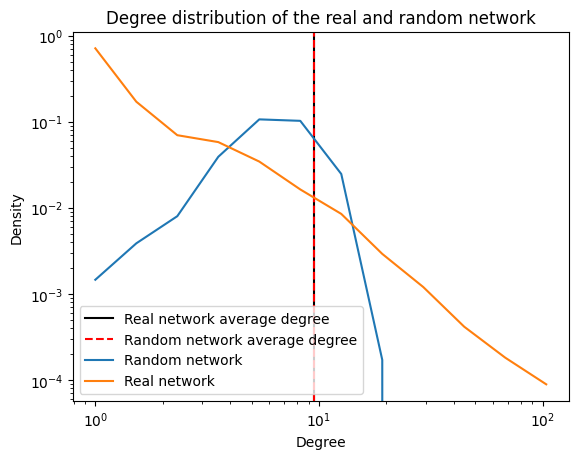

In [57]:
# Make a plot of the degree distribution
def make_plot(bins: list[list[int]], hists: list[list[int]], title: str, labels: list[str]):
    """
    Plot multiple histograms on a logarithmic scale.

    Parameters:
        bins (list[list[int]]): A list of bin edges for each histogram.
        hists (list[list[int]]): A list of histogram values for each bin.
        title (str): The title of the plot.
        labels (list[str]): A list of labels for each histogram.

    Returns:
        None
    """
    
    for bin, hist, label in zip(bins, hists, labels):
        plt.plot(bin[:-1], hist, label=label)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Degree')
    plt.ylabel('Density')
    plt.title(title)
    plt.legend()
    plt.savefig(f'{image_folder}Degree_distribution.png', bbox_inches='tight')
    plt.show()

# Compute the distribution of degree for the random network
degree_sequence_rd = [d for _, d in G_rand.degree()]
hist_rd, bins_rd = np.histogram(degree_sequence_rd, bins=np.logspace(0, 2.2, 13), density=True)

# Compute the distribution of degree for the real network
degree_sequence = [d for _, d in G.degree()]
hist_r, bins_r = np.histogram(degree_sequence, bins=np.logspace(0, 2.2, 13), density=True)

plt.axvline(k, color='black', linestyle='-', label='Real network average degree')
plt.axvline(np.mean(degree_sequence_rd), color='red', linestyle='--', label='Random network average degree')

make_plot([bins_rd, bins_r], [hist_rd, hist_r], 'Degree distribution of the real and random network', ['Random network', 'Real network'])

We see that the real network has a very distinctively different degree distributuion from the random network. Specifically we see that there a much bigger amount of nodes with a few connections and that there exists an amount of 'hubs' which have a much higher degree $>k$.

We can still investigate how these hubs are interconnected. We can calculate the assortativity of the nodes,first we have turned the graph into a undirected network to calculate the assortativity:

In [58]:
def degree_assortativity(G: nx.Graph) -> float:
    """
    Calculate the degree assortativity coefficient of a graph.

    The degree assortativity coefficient measures the correlation between the degrees of connected nodes in a graph.
    It quantifies the tendency of nodes with similar degrees to be connected to each other.

    Parameters:
    - G (networkx.Graph): The input graph.

    Returns:
    - r (float): The degree assortativity coefficient of the graph.

    Prerequisites:
    - The input graph G should be an instance of the networkx.Graph class.
    - The graph should have at least one edge.

    """

    k_u = []
    k_v = []
    for u, v in G.edges():
        k_u.append(G.degree(u))
        k_v.append(G.degree(v))
    
    for x, y in G.edges():
        k_u.append(G.degree(y))
        k_v.append(G.degree(x))
    
    k_u = np.array(k_u)
    k_v = np.array(k_v)
    r = ((np.mean(k_u * k_v) - np.mean(k_u) * np.mean(k_v)) /
         (np.sqrt(np.mean(k_u**2) - np.mean(k_u)**2) * np.sqrt(np.mean(k_v**2) - np.mean(k_v)**2)))

    return r

r_degree = degree_assortativity(G.to_undirected())

print(f"Degree assortativity of the real network: {r_degree:.5f}")

Degree assortativity of the real network: -0.18327


We see that the network is dissortative meaning that nodes with high degree generally link to nodes with a low degree.

To have some sort of measure to compare this dissortativity to we make a random model based on a configuration model with the following properties:

1. It should not have multilinks
2. It should not have self-loops

This forces the graph to be simple and it will therefore develop structural disassortativity. This is something we want as we want to make a test which tests if the dissortativity displayed by the Pypi network is significant or simply a product of the fact that a package can't have itself as a dependency and that it of course can't depend several times on another package, it simply depends on a package or not.

In [59]:
# Configuation model: random network with a pre-defined degree sequence
def configuration_model(G: nx.Graph) -> nx.Graph:
    """
    Generates a configuration model graph based on the input graph G.

    The configuration model is a random graph model that preserves the degree sequence of the input graph.
    It generates a new graph by randomly rewiring edges while maintaining the same degree distribution.

    Parameters:
    - G (nx.Graph): The input graph.

    Returns:
    - nx.Graph: The generated configuration model graph.

    Prerequisites:
    - The input graph G should be an instance of the networkx Graph class.
    - The input graph G should have at least one edge.

    """

    G_copy = G.copy()
    edges = list(G_copy.edges())
    idxs = list(range(len(edges)))
    num_swaps = 10 * G_copy.number_of_edges()

    for _ in range(num_swaps):
        # Select two edges
        idx1, idx2 = random.sample(idxs, 2)
        e1, e2 = edges[idx1], edges[idx2]

        # Flip the direction of e1 50% of the time
        if random.random() < 0.5:
            e1 = (e1[1], e1[0])

        # Ensure new edges do not exist
        if e1[0] not in G_copy.neighbors(e2[1]) and e2[0] not in G_copy.neighbors(e1[1]):
            
            # Remove old edges and add new edges
            G_copy.remove_edges_from([e1, e2])
            G_copy.add_edges_from([(e1[0], e2[1]), (e2[0], e1[1])])
    
            edges[idx1] = (e1[0], e2[1])
            edges[idx2] = (e2[0], e1[1])

    return G_copy

G_undir = G.to_undirected()
G_config = configuration_model(G_undir)

# Assert that the degree sequence of the configuration model is the same as the real network
assert all([G_undir.degree(node) == G_config.degree(node) for node in G_undir.nodes])

In the end we check that all the nodes in the two networks have the same degree, thereby confirming the algorithm is working as expected. Now we will generate 20 different random networks with the configuration model to see if they're significantly different from the Pypi network:

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [19:47<00:00, 59.37s/it]


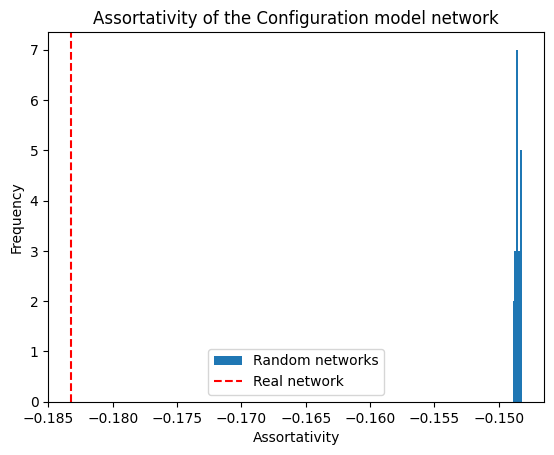

In [60]:
# Calculate the degree assortativity of multiple configuration models
assortativities = []
for _ in tqdm(range(20)):
    G_config = configuration_model(G_undir)
    r_config = degree_assortativity(G_config)
    assortativities.append(r_config)

# Plot the distribution of the assortativities
plt.hist(assortativities, bins=5, label='Random networks')

# Plot the assortativity of the original network
plt.axvline(r_degree, color='red', linestyle='--', label='Real network')
plt.xlabel('Assortativity')
plt.ylabel('Frequency')
plt.title('Assortativity of the Configuration model network')
plt.legend()
plt.savefig(f'{image_folder}Assortativity.png', bbox_inches='tight')
plt.show()

We see that the real network has a lower dissortativity than the random networks. This indicates that the dissortativity of the Pypi network is not just due to structural dissortativity, however this test was a simplification for the sake of understanding.

A much better test would be to let the Pypi network keep its directed property and calculate the assortativity based on direction and make a new configuration model algorithm with a added requirement:

1. It should not have multilinks
2. It should not have self-loops
3. It should let the in- and out-degree stay the same during node swapping

Furthermore we need to change the assortativity calculation to take account of pairs connected nodes (node: A and node: B) were we consider the in-degree of A, the in-degree of B and the out-degree of A, and the out-degree of B and all combinations of these.

This is done below:

In [61]:
def degree_assortativity_directed(G: nx.DiGraph):
    """
    Calculate the degree assortativity for a directed graph.

    Parameters:
    - G (nx.DiGraph): A directed graph.

    Returns:
    - r_in_in (float): Degree assortativity for in-degree of nodes.
    - r_out_out (float): Degree assortativity for out-degree of nodes.
    - r_in_out (float): Degree assortativity between in-degree and out-degree of nodes.
    - r_out_in (float): Degree assortativity between out-degree and in-degree of nodes.

    Prerequisites:
    - The input graph G should be a directed graph (nx.DiGraph).
    - The graph G should have nodes and edges defined.
    """

    # k_u and k_v are the degrees of nodes u and v, respectively
    # We get the k_u_in, k_u_out, k_v_in and k_v_out
    k_u_in = []
    k_u_out = []
    k_v_in = []
    k_v_out = []

    for u, v in G.edges():
        k_u_in.append(G.in_degree(u))
        k_v_in.append(G.in_degree(v))
        k_u_out.append(G.out_degree(u))
        k_v_out.append(G.out_degree(v))

    k_u_in = np.array(k_u_in)
    k_v_in = np.array(k_v_in)
    k_u_out = np.array(k_u_out)
    k_v_out = np.array(k_v_out)

    r_in_in = ((np.mean(k_u_in * k_v_in) - np.mean(k_u_in) * np.mean(k_v_in)) /
            (np.sqrt(np.mean(k_u_in**2) - np.mean(k_u_in)**2) * np.sqrt(np.mean(k_v_in**2) - np.mean(k_v_in)**2)))
    
    r_out_out = ((np.mean(k_u_out * k_v_out) - np.mean(k_u_out) * np.mean(k_v_out)) /
            (np.sqrt(np.mean(k_u_out**2) - np.mean(k_u_out)**2) * np.sqrt(np.mean(k_v_out**2) - np.mean(k_v_out)**2)))
    
    r_in_out = ((np.mean(k_u_in * k_v_out) - np.mean(k_u_in) * np.mean(k_v_out)) /
            (np.sqrt(np.mean(k_u_in**2) - np.mean(k_u_in)**2) * np.sqrt(np.mean(k_v_out**2) - np.mean(k_v_out)**2)))
    
    r_out_in = ((np.mean(k_u_out * k_v_in) - np.mean(k_u_out) * np.mean(k_v_in)) /
            (np.sqrt(np.mean(k_u_out**2) - np.mean(k_u_out)**2) * np.sqrt(np.mean(k_v_in**2) - np.mean(k_v_in)**2)))


    return r_in_in, r_out_out, r_in_out, r_out_in

r_in_in_real, r_out_out_real, r_in_out_real, r_out_in_real = degree_assortativity_directed(G)

print(f"In-in degree assortativity of the real network: {r_in_in_real:.5f}")
print(f"Out-out degree assortativity of the real network: {r_out_out_real:.5f}")
print(f"In-out degree assortativity of the real network: {r_in_out_real:.5f}")
print(f"Out-in degree assortativity of the real network: {r_out_in_real:.5f}")

In-in degree assortativity of the real network: 0.00140
Out-out degree assortativity of the real network: -0.01516
In-out degree assortativity of the real network: 0.00238
Out-in degree assortativity of the real network: -0.18149


We see that the in-in degree assortativity and the in-out degree assortativity is very sligly positive but close to neutral (0). 

However the out-out degree is slightly more disassortative with a value of -0.015. Meaning that packages that depend on a lot of packages have a tendency to be linked with packages that depend on less packages. 

(As we defined that a package points to its dependency)

Furthermore we see even stronger signs of disassortativity with the out-in degree, this means that packages that depend on a lot of packages have a tendency to be linked to packages which has fewer packages depending on it. 

-----------------------------------------------

We introduce a new way to measure assortativity: Degree correlation. Below we implement an algorithm which calculates the four possible degree correlations.

We define this algorithm as to calculate the degree correlation; $k_{nn}^{\alpha, \beta}(k)$ where $\alpha$ and $\beta$ refer to the in and out degrees. It mirrors the undirected function for degree correlation:
$$k_{nn}(k_i) = \frac{1}{k_i} \sum^{N}_{j=1}{A_{ij}k_j}$$
where $A_{ij}$ is the adjacency matrix.

We use the same calculation but we just consider the in/out degree too, hereby making a familiy of functions which consider different combinations of $\alpha$: in, and $\beta$: out degree for the node $k_i$:

$$k_{nn}^{\alpha, \beta}(k_i^{\alpha, \beta}) = \frac{1}{k_i^{\alpha, \beta}} \sum^{N}_{j=1}{A_{ij}k_j^{\alpha, \beta}}$$

This is shown below:

In [65]:
def degree_correlation_directed(G: nx.DiGraph):
    """
    Calculate the degree correlation for a directed graph.

    Parameters:
    - G (nx.DiGraph): A directed graph.

    Returns:
    - k_in_in (dict): A dictionary with the average neighbor in-degree of node with in-degree k'.
    - k_in_out (dict): A dictionary with the average neighbor out-degree of node with in-degree k'.
    - k_out_in (dict): A dictionary with the average neighbor in-degree of node with out-degree k'.
    - k_out_out (dict): A dictionary with the average neighbor out-degree of node with out-degree k'.

    Prerequisites:
    - The input graph G should be a directed graph (nx.DiGraph).
    - The graph G should have nodes and edges defined.
    """
    
    # For each node with degree k' we want to get the average of neighbor degree in and neighbor degree out
    k_in_in = {}
    k_in_out = {}
    k_out_in = {}
    k_out_out = {}

    for u, v in G.edges():
        if G.in_degree(u) not in k_in_in:
            k_in_in[G.in_degree(u)] = []
        if G.in_degree(u) not in k_in_out:
            k_in_out[G.in_degree(u)] = []
        if G.out_degree(u) not in k_out_in:
            k_out_in[G.out_degree(u)] = []
        if G.out_degree(u) not in k_out_out:
            k_out_out[G.out_degree(u)] = []

    for u, v in G.edges():
        k_in_in[G.in_degree(u)].append(G.in_degree(v))
        k_in_out[G.in_degree(u)].append(G.out_degree(v))
        k_out_in[G.out_degree(u)].append(G.in_degree(v))
        k_out_out[G.out_degree(u)].append(G.out_degree(v))
    
    
    k_in_in = {k: np.mean(v) for k, v in k_in_in.items()}
    k_in_out = {k: np.mean(v) for k, v in k_in_out.items()}
    k_out_in = {k: np.mean(v) for k, v in k_out_in.items()}
    k_out_out = {k: np.mean(v) for k, v in k_out_out.items()}

    return k_in_in, k_in_out, k_out_in, k_out_out

k_in_in, k_in_out, k_out_in, k_out_out = degree_correlation_directed(G)

print(f"Average neighbor in-degree of node with in-degree k': {k_in_in}")
print(f"Average neighbor out-degree of node with in-degree k': {k_in_out}")
print(f"Average neighbor in-degree of node with out-degree k': {k_out_in}")
print(f"Average neighbor out-degree of node with out-degree k': {k_out_out}")

Average neighbor in-degree of node with in-degree k': {0: 629.8249263825757, 1: 510.66217303822935, 1231: 683.4736842105264, 101: 598.6285714285714, 1014: 1034.3333333333333, 182: 2438.5, 2: 596.9806835066864, 26: 524.0666666666667, 27: 757.625, 183: 128.33333333333334, 31: 468.97222222222223, 22: 560.0454545454545, 85: 568.6153846153846, 5: 528.7368421052631, 10: 594.2592592592592, 3: 656.3850129198967, 60: 1205.75, 374: 1807.4, 25: 1043.2727272727273, 113: 316.1666666666667, 69: 1041.5, 41: 529.6428571428571, 4: 536.3589743589744, 11: 1169.225806451613, 13: 705.2272727272727, 36: 1695.3333333333333, 21: 493.25, 42: 430.46875, 12: 641.75, 15: 815.12, 30: 485.34, 47: 739.9473684210526, 44: 1851.0, 35: 799.1666666666666, 8: 848.6785714285714, 179: 773.0, 98: 1828.0, 7: 692.9833333333333, 9: 518.5762711864406, 51: 485.57894736842104, 14: 494.93939393939394, 16: 50.348765432098766, 34: 1040.5714285714287, 19: 498.8, 49: 1223.2, 103: 461.4, 6: 788.1704545454545, 20: 289.9, 61: 747.28571428

We see that the avereage neighbor in degree of nodes with in degree zero is 629.8. This mean that packages which are the requirement of no other packages generally are pointing to packages which are the requirement of many packages. This makes a lot of sense as there generally are some extremely popular packages which many packages have as requirement but these packages themselves might not be the dependency of any other package.

These results are interesting but it would take a long time to go through all the values. Therefore we've plotted them below:

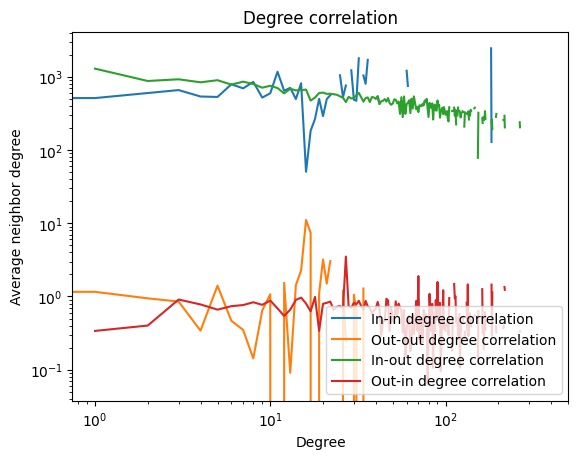

In [66]:
# Get the x values from the keys of the dictionaries
x_values = list(range(0,1000))

# Get the y values from the values of the dictionaries
y_values_in_in = [k_in_in.get(x, np.nan) for x in x_values]
y_values_out_out = [k_in_out.get(x, np.nan) for x in x_values]
y_values_in_out = [k_out_in.get(x, np.nan) for x in x_values]
y_values_out_in = [k_out_out.get(x, np.nan) for x in x_values]

# Plot the degree correlation
plt.plot(x_values, y_values_in_in, label='In-in degree correlation')
plt.plot(x_values, y_values_out_out, label='Out-out degree correlation')
plt.plot(x_values, y_values_in_out, label='In-out degree correlation')
plt.plot(x_values, y_values_out_in, label='Out-in degree correlation')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Degree")
plt.ylabel("Average neighbor degree")
plt.legend(loc='lower right')
plt.title("Degree correlation")
plt.savefig(f'{image_folder}Degree_correlation.png', bbox_inches='tight')
plt.show()

The plot displays clear disassortative behaviorfor the in-out degree correlation and the out-out degree correlation (the negative slope). Also the Out-out and out-in degree correlations have some very steep dips.

--------------------------

However both of these results (directed degree correlation and directed assortativity) should be compared to a random model to check if they're just displaying structural patterns or if theres any significance to the results i.e. not randomly appearing. Therefore we've made a degree preserving randomization (R-S randomization) which follow the 3 rules set earlier:

1. It should not have multilinks
2. It should not have self-loops
3. It should let the in- and out-degree stay the same during node swapping

This is done below:

In [67]:
# We do a degree preserving randomisation : R-S randomization to the plot
def degree_preserving_randomization(G: nx.DiGraph):
    """
    Perform degree-preserving randomization of a directed graph.

    Parameters:
    - G (nx.DiGraph): A directed graph.

    Returns:
    - G_copy (nx.DiGraph): The degree-preserving randomized graph.

    Prerequisites:
    - The input graph G should be a directed graph (nx.DiGraph).
    - The graph G should have nodes and edges defined.
    """

    # Create a copy of the graph
    G_copy = G.copy()

    # Get the edges and indexes
    edges = list(G_copy.edges())
    idxs = list(range(len(edges)))

    # Get the number of edges
    num_swaps = 10 * G_copy.number_of_edges()

    # For each swap
    for _ in range(num_swaps):
        # Select two sets of connected
        idx1, idx2 = random.sample(idxs, 2)
        u, v = edges[idx1]
        x, y = edges[idx2]

        # Ensure distinct nodes
        if len(set([u, v, x, y])) < 4:
            continue

        # Ensure that the new edges do not exist
        if x not in G_copy.neighbors(v) and y not in G_copy.neighbors(u):
            # Remove the old edges
            G_copy.remove_edges_from([(u, v), (x, y)])

            # Add the new edges
            G_copy.add_edges_from([(u, y), (x, v)])

            # Update the edges
            edges[idx1] = (u, y)
            edges[idx2] = (x, v)

    return G_copy

G_degree_randomized = degree_preserving_randomization(G)
k_in_in_randomized, k_in_out_randomized, k_out_in_randomized, k_out_out_randomized = degree_correlation_directed(G_degree_randomized)

This we will do 50 times and display on the same plots as before. This way will we see if the Pypi network is significantly different than the random models and if the disassortativity is not only due to structural disassortativity.

In [68]:
# We collect the values created by the R-S randomized graphs
r_in_in_R_S = []
r_out_out_R_S = []
r_in_out_R_S = []
r_out_in_R_S = []

y_values_in_in_randomized = []
y_values_out_out_randomized = []

y_values_in_out_randomized = []
y_values_out_in_randomized = []


for _ in tqdm(range(50)):
    G_r_s = degree_preserving_randomization(G)

    r_in_in, r_out_out, r_in_out, r_out_in = degree_assortativity_directed(G_r_s)
    r_in_in_R_S.append(r_in_in)
    r_out_out_R_S.append(r_out_out)
    r_in_out_R_S.append(r_in_out)
    r_out_in_R_S.append(r_out_in)

    k_in_in_randomized, k_in_out_randomized, k_out_in_randomized, k_out_out_randomized = degree_correlation_directed(G_r_s)
    y_values_in_in_randomized.append([k_in_in_randomized.get(x, np.nan) for x in x_values])
    y_values_out_out_randomized.append([k_in_out_randomized.get(x, np.nan) for x in x_values])
    y_values_in_out_randomized.append([k_out_in_randomized.get(x, np.nan) for x in x_values])
    y_values_out_in_randomized.append([k_out_out_randomized.get(x, np.nan) for x in x_values])

# Get the mean
y_values_in_in_randomized_mean = np.mean(y_values_in_in_randomized, axis=0)
y_values_out_out_randomized_mean = np.mean(y_values_out_out_randomized, axis=0)
y_values_in_out_randomized_mean = np.mean(y_values_in_out_randomized, axis=0)
y_values_out_in_randomized_mean = np.mean(y_values_out_in_randomized, axis=0)

# Get the std
y_values_in_in_randomized_std = np.std(y_values_in_in_randomized, axis=0)
y_values_out_out_randomized_std = np.std(y_values_out_out_randomized, axis=0)
y_values_in_out_randomized_std = np.std(y_values_in_out_randomized, axis=0)
y_values_out_in_randomized_std = np.std(y_values_out_in_randomized, axis=0)

100%|██████████| 50/50 [20:42<00:00, 24.86s/it]


We show the degree correlation while displaying the 50 random networks mean value and show 2 standard deviations over and under the mean:

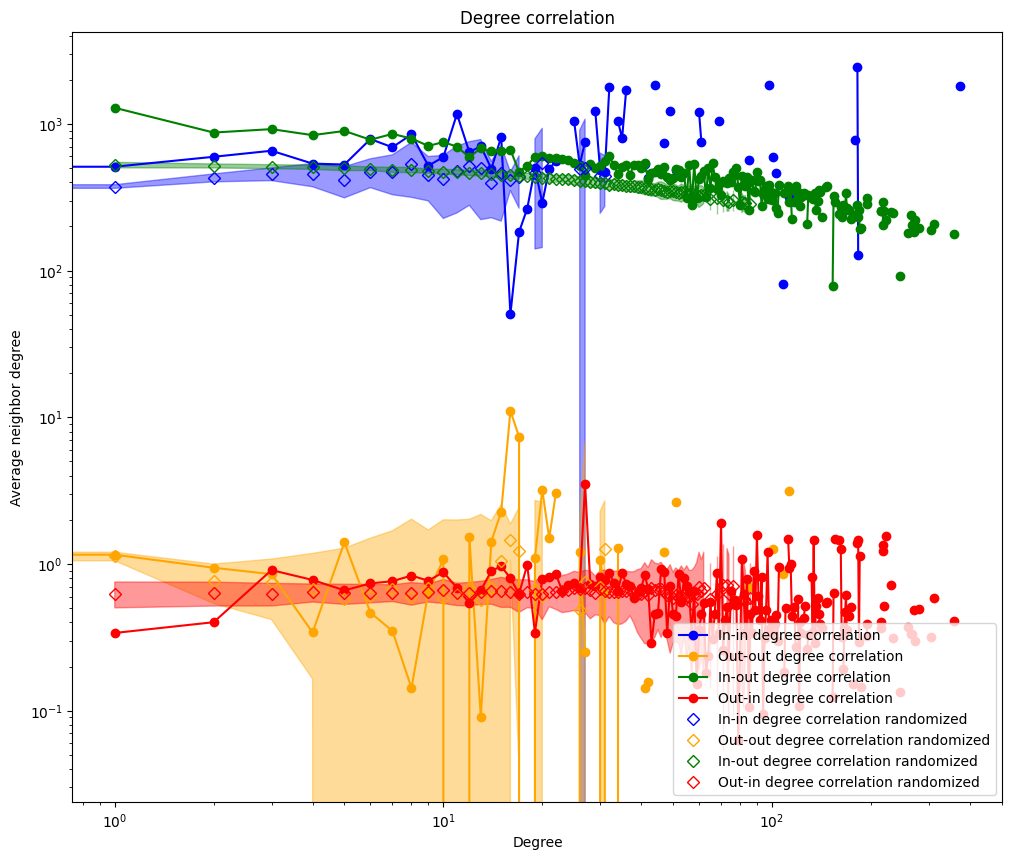

In [69]:
# Get the y values from the values of the dictionaries for the randomized network

# Plot the degree correlation
plt.figure(figsize=(12, 10))

plt.plot(x_values, y_values_in_in, label='In-in degree correlation', color='blue', marker = 'o')
plt.plot(x_values, y_values_out_out, label='Out-out degree correlation', color='orange', marker='o')
plt.plot(x_values, y_values_in_out, label='In-out degree correlation', color='green', marker='o')
plt.plot(x_values, y_values_out_in, label='Out-in degree correlation', color='red', marker='o')

plt.plot(x_values, y_values_in_in_randomized_mean, label='In-in degree correlation randomized', linestyle='None', marker = 'D', color = 'blue', markerfacecolor = 'None')
plt.plot(x_values, y_values_out_out_randomized_mean, label='Out-out degree correlation randomized', linestyle='None', marker = 'D', color = 'orange', markerfacecolor = 'None') 
plt.plot(x_values, y_values_in_out_randomized_mean, label='In-out degree correlation randomized', linestyle='None', marker = 'D', color = 'green', markerfacecolor = 'None')
plt.plot(x_values, y_values_out_in_randomized_mean, label='Out-in degree correlation randomized', linestyle='None', marker = 'D', color = 'red', markerfacecolor = 'None')

lower_bound_in_in, upper_bound_in_in = y_values_in_in_randomized_mean - y_values_in_in_randomized_std*2, y_values_in_in_randomized_mean + y_values_in_in_randomized_std*2
lower_bound_out_out, upper_bound_out_out = y_values_out_out_randomized_mean - y_values_out_out_randomized_std*2, y_values_out_out_randomized_mean + y_values_out_out_randomized_std*2
lower_bound_in_out, upper_bound_in_out = y_values_in_out_randomized_mean - y_values_in_out_randomized_std*2, y_values_in_out_randomized_mean + y_values_in_out_randomized_std*2
lower_bound_out_in, upper_bound_out_in = y_values_out_in_randomized_mean - y_values_out_in_randomized_std*2, y_values_out_in_randomized_mean + y_values_out_in_randomized_std*2

plt.fill_between(x_values, lower_bound_in_in, upper_bound_in_in, color='blue', alpha=0.4)
plt.fill_between(x_values, lower_bound_out_out, upper_bound_out_out, color='orange', alpha=0.4)
plt.fill_between(x_values, lower_bound_in_out, upper_bound_in_out, color='green', alpha=0.4)
plt.fill_between(x_values, lower_bound_out_in, upper_bound_out_in, color='red', alpha=0.4)

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Degree")
plt.ylabel("Average neighbor degree")
plt.legend(loc='lower right')
plt.title("Degree correlation")
plt.savefig(f'{image_folder}Degree_correlation_randomized.png', bbox_inches='tight')
plt.show()

This plot also shows clear disassortative behavior for the in-out degree correlation however it also shows that the disassortativity for the random models in-out is much flatter and looks more linear. This indicates that the disassortativity is in the Pypi network is not due to structural disassortativity. However the random networks have a very large range for the out-out degree correlation so it's hard to say anything definitive based on this alone. Generally the values of the real network are outside the range of the random models.

---------------------------------

Below we plot the assortativities:

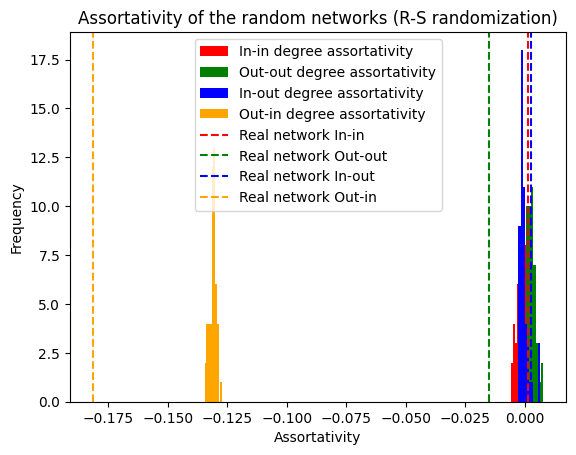

In [70]:
# Make the same plots with the degree preserving randomization

# Plot the distribution of the assortativities
plt.hist(r_in_in_R_S, bins=10, label='In-in degree assortativity', color='red')
plt.hist(r_out_out_R_S, bins=10, label='Out-out degree assortativity', color='green')
plt.hist(r_in_out_R_S, bins=10, label='In-out degree assortativity', color='blue')
plt.hist(r_out_in_R_S, bins=10, label='Out-in degree assortativity', color='orange')

# Plot the assortativity of the original network
plt.axvline(r_in_in_real, color='red', linestyle='--', label='Real network In-in')
plt.axvline(r_out_out_real, color='green', linestyle='--', label='Real network Out-out')
plt.axvline(r_in_out_real, color='blue', linestyle='--', label='Real network In-out')
plt.axvline(r_out_in_real, color='orange', linestyle='--', label='Real network Out-in')

plt.xlabel('Assortativity')
plt.ylabel('Frequency')
plt.title('Assortativity of the random networks (R-S randomization)')
plt.legend()
plt.savefig(f'{image_folder}Assortativity_column_R_S.png', bbox_inches='tight')
plt.show()

Again we see that especially the out-in assortativity is different from the random models and also the out-out assortativity.

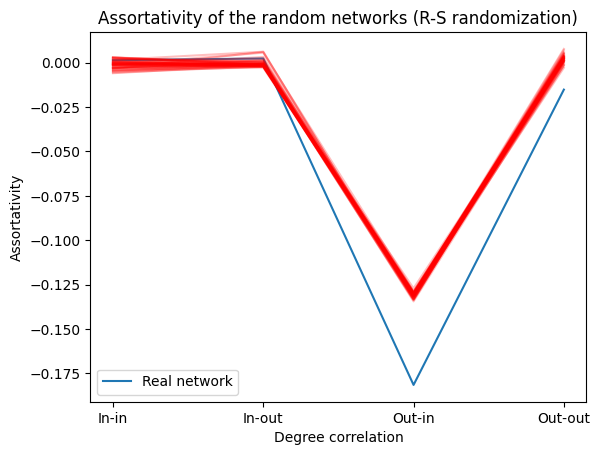

In [71]:
# Instead plot it as a line plot where the x_values are in_in, in_out, out_in, out_out:
x_values = ['In-in', 'In-out', 'Out-in', 'Out-out']

# Get the y values from the values of the dictionaries
y_values = [r_in_in_real, r_in_out_real, r_out_in_real, r_out_out_real]

fig = plt.figure()
plt.plot(x_values, y_values, label='Real network')
for i, (r_in_in, r_out_out, r_in_out, r_out_in) in enumerate(zip(r_in_in_R_S, r_out_out_R_S, r_in_out_R_S, r_out_in_R_S)):
    y_values = [r_in_in, r_in_out, r_out_in, r_out_out]
    plt.plot(x_values, y_values, alpha=0.25, color='red')

plt.xlabel("Degree correlation")
plt.ylabel("Assortativity")
plt.title("Assortativity of the random networks (R-S randomization)")
plt.legend()
plt.savefig(f'{image_folder}Assortativity_lineplot_R_S.png', bbox_inches='tight')
plt.show()

Finally the out-in degree is especially different from the random networks which are shown in red in the above plot.

### Part 1 of Conclusion on the Graph Analysis.
The network of github is not random and it shows very clear signs of dissortativity, specifically for the out-in and a little less for the out-out degrees. This indicates that packages in the network which have a lot of packages depending on the them dont depend on a lot of packages themselves.

-------------------

We also want to investigate which packages are most central in this graph. That we will do in the rest of the graph analysis. First we plot the closeness centrality and the eignevector centrality:

In [72]:
# Find the 5 most central packages according to degree centrality.
closeness_centrality = nx.closeness_centrality(G)
sorted_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
print(f'The 5 most central packages according to closeness centrality are: {[str(package) for package, centrality in sorted_closeness_centrality[:5]]}')

# Find the 5 most central packages according to eigenvector centrality.
eigenvector_centrality = nx.eigenvector_centrality(G)
sorted_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)
print(f'The 5 most central packages according to eigenvector centrality are: {[str(package) for package, centrality in sorted_eigenvector_centrality[:5]]}')

The 5 most central packages according to closeness centrality are: ['pytest', 'requests', 'numpy', 'pytest-cov', 'pandas']
The 5 most central packages according to eigenvector centrality are: ['dissect.cstruct', 'dissect.target', 'dissect.archive', 'dissect.btrfs', 'dissect.cim']


It makes a lot of sense that pytest, requests, numpy, pytest-cov, and pandas are the most central packages according to closeness centrality as these are extremely popular packages that arevery commonly used.

It also makes sense that according to eigenvector centrality the dissect packages are the most central as they're part of a 'dissect' family of packages which all just depend on eachother. So these will score high in the eigenvector centrality measure.

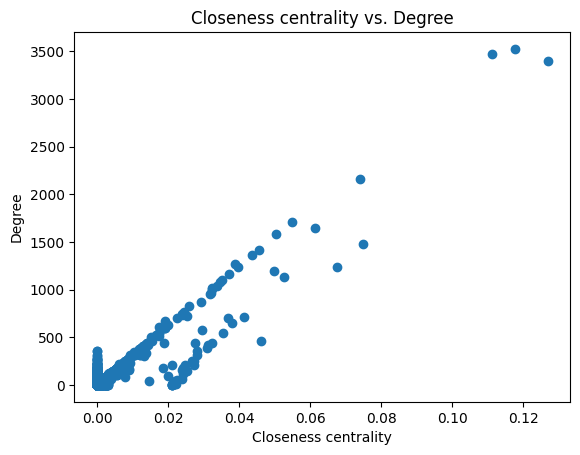

In [73]:
closeness_centrality = nx.closeness_centrality(G)
degree = dict(G.degree())
plt.scatter(list(closeness_centrality.values()), list(degree.values()))
plt.xlabel('Closeness centrality')
plt.ylabel('Degree')
plt.title('Closeness centrality vs. Degree')
plt.savefig(f'{image_folder}Closeness_vs_Degree.png', bbox_inches='tight')
plt.show()

Here we see that there is a linear relationship between closeness centrality and the degree. So the nodes with the biggest degree can 'reach' the most nodes.

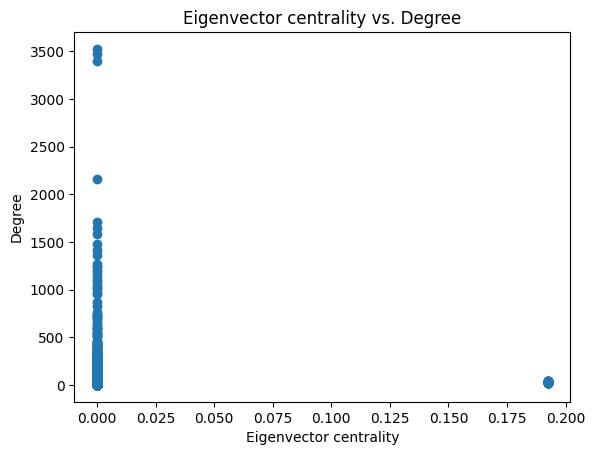

In [74]:
eigenvector_centrality = nx.eigenvector_centrality(G)
degree = dict(G.degree())
plt.scatter(list(eigenvector_centrality.values()), list(degree.values()))
plt.xlabel('Eigenvector centrality')
plt.ylabel('Degree')
plt.title('Eigenvector centrality vs. Degree')
plt.savefig(f'{image_folder}Eigenvector_vs_Degree.png', bbox_inches='tight')
plt.show()

On the plot above we see that most of the packages don't have 'important' neighbors. Almost all of the nodes -no matter the degree- has 'unimportant' neighbors all beside the dissect cluster from before.

We can also simply plot the most used packages and the packages with the most dependencies:

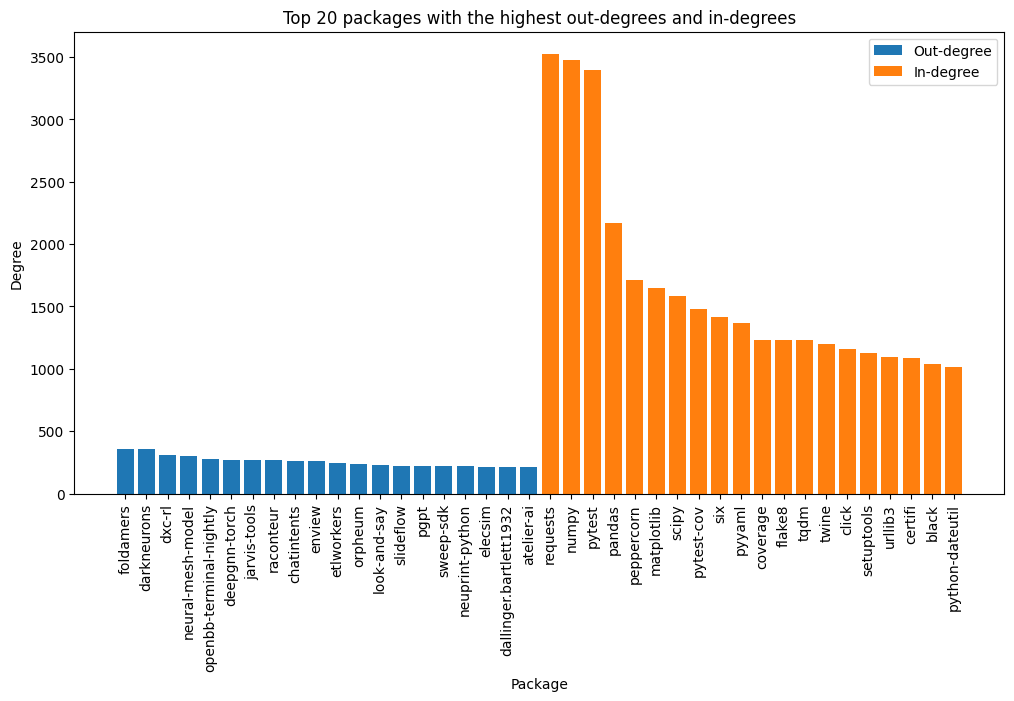

In [75]:
#Plot of the 20 packages with the highest out-degrees and 20 packages with the highest in degrees:

# Get the out-degrees and in-degrees
out_degrees = dict(G.out_degree())
in_degrees = dict(G.in_degree())

# Sort them
sorted_out_degrees = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)
sorted_in_degrees = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)

# Get the top 20 packages
top_out_degrees = sorted_out_degrees[:20]
top_in_degrees = sorted_in_degrees[:20]

# Bar plot of the degrees
plt.figure(figsize=(12, 6))
plt.bar([package for package, degree in top_out_degrees], [degree for package, degree in top_out_degrees], label='Out-degree')
plt.bar([package for package, degree in top_in_degrees], [degree for package, degree in top_in_degrees], label='In-degree')
plt.xticks(rotation=90)
plt.xlabel('Package')
plt.ylabel('Degree')
plt.title('Top 20 packages with the highest out-degrees and in-degrees')
plt.legend()
plt.savefig(f'{image_folder}Top_20_degrees.png', bbox_inches='tight')
plt.show()

As expected we see some very well known packages which are often dependencies. The packages with the most dependencies are however much less known.

### Part 2 of Conclusion on Graph Analysis.
The centrality analysis has given us the understanding that there are some important hubs (Numpy, pytest, pandas) which are dependencies for many packages. Furthermore most important packages are used across many unimportant packages.

---------

Together with the earlier graph analysis we have found out that the pypi package network is not random and tends to be disassortative. This tells us that there exists many packages in the python packages index (Pypi) which use central packages but do not themselves get used by any other packages.

## Textual analysis of the found communities

In [30]:
G_undir = G.to_undirected()
partition = nx.community.louvain_communities(G_undir)
print(len(partition))
print({i: len([v for v in p]) for i, p in enumerate(partition)})
print(nx.community.modularity(G_undir, partition))
partitioning = {node: i for i, p in enumerate(partition) for node in p}

77
{0: 3114, 1: 870, 2: 2292, 3: 1602, 4: 1646, 5: 1365, 6: 94, 7: 5, 8: 8, 9: 32, 10: 3, 11: 98, 12: 65, 13: 13, 14: 3, 15: 2783, 16: 14, 17: 6, 18: 6, 19: 13, 20: 5, 21: 9, 22: 731, 23: 1726, 24: 5764, 25: 3, 26: 18, 27: 8, 28: 4, 29: 7, 30: 7, 31: 7, 32: 209, 33: 4, 34: 19, 35: 3, 36: 6, 37: 17, 38: 4, 39: 314, 40: 490, 41: 14, 42: 3, 43: 6644, 44: 4, 45: 292, 46: 7, 47: 4, 48: 3, 49: 3, 50: 4, 51: 6, 52: 3, 53: 13, 54: 13, 55: 4, 56: 4, 57: 3, 58: 515, 59: 8, 60: 6, 61: 6, 62: 3, 63: 7, 64: 28, 65: 4, 66: 16, 67: 15, 68: 5, 69: 240, 70: 8, 71: 8, 72: 6, 73: 5, 74: 4, 75: 6, 76: 3}
0.5225124432273905


In [32]:
# Map a community number into one of 47 unique colors
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
cmap = plt.get_cmap('gist_ncar')
colors = [cmap(i) for i in np.linspace(0, 1, len(partition))]
colors = [colors[community] for community in partitioning.values()]

# Map the color to the corresponding package and save the pairs into a csv file
community_color = {package: color for package, color in zip(G.nodes, colors)}
community_color = pd.DataFrame(community_color.items(), columns=['id', 'color'])
community_color.to_csv("data/community_color.csv", index=False, escapechar="\\")

In [33]:
df = pd.read_csv("data/nodes_data.csv")
df = df.dropna(subset=['readme_text'])
# # Take 1/10 of the data
# df_subset = df.sample(frac=0.1, random_state=42)
# df = df_subset

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def tokenize(text, stop_words=stop_words, stemmer=stemmer):
    """
    Tokenize the text by removing stopwords, punctuation, and stemming the words.

    Parameters:
    - text (str): The input text.
    - stop_words (set): A set of stopwords.
    - stemmer (PorterStemmer): A stemmer object.

    Returns:
    - tokens (list): A list of tokens.
    """
    
    if text is None or '':
        return ''
    
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]

    tokens = [stemmer.stem(word) for word in tokens]
    return tokens

# Apply the function to the readme's
df["tokens"] = df["readme_text"].apply(tokenize)

# Save the dataframe to a csv file
df.to_csv("data/nodes_tokens.csv", index=False)

# Combine the tokens from all abstracts into one comprehensive list.
all_tokens = df["tokens"].sum()

In [34]:
# Bigrams and contingency tables

# Function that creates bigrams from a list of tokens
bigrams = list(make_bigrams(all_tokens))
bigram_counts = Counter(bigrams)

# Function that creates a contingency table for a bigram
# Create a BigramCollocationFinder object that also stores tables at the same time
finder = BigramCollocationFinder.from_words(all_tokens)

# Computes for each unique bigram the chi-squared statistic between the observed and expected contingency tables
# Filter bigrams based on chi-squared
collocations_chisq = finder.score_ngrams(BigramAssocMeasures().chi_sq)

# Compute p-values for the chi-squared statistics
# Calculate chi-squared to get p-value
collocations_p = []
for bigram, chi_squared in tqdm(collocations_chisq):
    collocations_p.append((bigram, stats.chi2.sf(chi_squared, 1)))

# Find the list of bigrams that appear more than 50 times and have p-value smaller than 0.001
# Filter collocations based on p-value
collocations = [bigram for bigram, p_value in collocations_p if bigram_counts[bigram] > 50 and p_value < 0.001]

# Find the top 20 of them by number of occurrences
print(f'Top 20 collocations by number of occurrences: {collocations[:20]}')

# Combine collocations into a single token
collocation_tokens = ['_'.join(bigram) for bigram in collocations]

100%|██████████| 2416327/2416327 [05:14<00:00, 7688.09it/s]


Top 20 collocations by number of occurrences: [('auditlogauditl', 'jsonifierjsonifi'), ('endpointendpoint', 'tencentcloudapicomcvm'), ('hollinworth', 'yoan'), ('jsonifierjsonifi', 'sentrys'), ('secretidsecretkey', 'endpointendpoint'), ('uaio', 'uargpars'), ('umqttrobust', 'umqttsimpl'), ('restructuredtextrst', 'markdownmd'), ('yoan', 'blanc'), ('tencentcloudapicomcvm', 'cvmtencentcloudapicom'), ('ashton', 'honneck'), ('benesch', 'maksym'), ('kostya', 'leschenko'), ('leschenko', 'ashton'), ('maksym', 'balatsko'), ('blanc', 'kostya'), ('bratteng', 'nikhil'), ('nikhil', 'benesch'), ('carey', 'bratteng'), ('edmund', 'crosley')]


Interesting observation is that alot of the collocations found are names of productive github project developers such as Edmund Crosley or Maksym Balatsko.

In [44]:
print(f'Number of collocations: {len(collocation_tokens)}')

Number of collocations: 13581


In [35]:
def tokenize_with_collocations(text: str, collocations=collocation_tokens, stop_words=stop_words, stemmer=stemmer):
    """
    Tokenize the text by removing stopwords, punctuation, and stemming the words.

    Parameters:
    - text (str): The input text.
    - collocations (list): A list of collocations.
    - stop_words (set): A set of stopwords.
    - stemmer (PorterStemmer): A stemmer object.

    Returns:
    - tokens (list): A list of tokens.
    """

    if text is None or '':
        return ''
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # Check all tokens and replace collocations with a single token
    for i in range(len(tokens) - 1):
        if f'{tokens[i]}_{tokens[i + 1]}' in collocations:
            tokens[i] = f'{tokens[i]}_{tokens[i + 1]}'
            tokens[i + 1] = ''
    tokens = [word for word in tokens if word != '']

    return tokens

df = pd.read_csv("data/nodes_tokens.csv")

# Apply the function to the readme's
df["collocations"] = df["readme_text"].apply(tokenize_with_collocations)

# Save the dataframe to a csv file
df.to_csv("data/nodes_collocations.csv", index=False)

In [36]:
df = pd.read_csv("data/nodes_collocations.csv")

# Use the partitioning for the packages get a coloumn with their partitioning in the df:
df['partition'] = df['package'].map(partitioning)

# Save the dataframe to a csv file
df.to_csv("data/nodes_partition.csv", index=False)

In [53]:
df = pd.read_csv("data/nodes_partition.csv")

# Select the top 10 communities
top_10_communities = df['partition'].value_counts().index[:10]

# Filter the dataframe on the top 10 communities
df_top_10 = df[df['partition'].isin(top_10_communities)]

# Create a dictionary with the top 10 communities and the corresponding tokens
top_10_community_terms = {}

for community in top_10_communities:
    # The tokens are a long string but should be read as individual lists
    tokens = df_top_10[df_top_10['partition'] == community]['tokens'].apply(ast.literal_eval)
    tokens = [token for sublist in tokens for token in sublist] 
    # only use term frequency
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform([' '.join(tokens)])
    terms = vectorizer.get_feature_names_out()
    top_10_community_terms[community] = terms

# Get the 3 packages with most out nodes in each community
top_3_packages = {}

for community in top_10_communities:
    in_degrees = dict(G.in_degree())
    community_nodes = [node for node in G.nodes if partitioning[node] == community]
    in_degrees_community = {node: in_degrees[node] for node in community_nodes}
    top_3_packages[community] = sorted(in_degrees_community, key=in_degrees_community.get, reverse=True)[:3]

In [54]:
top_10_communities

Index([24.0, 43.0, 0.0, 15.0, 3.0, 5.0, 4.0, 23.0, 2.0, 1.0], dtype='float64', name='partition')

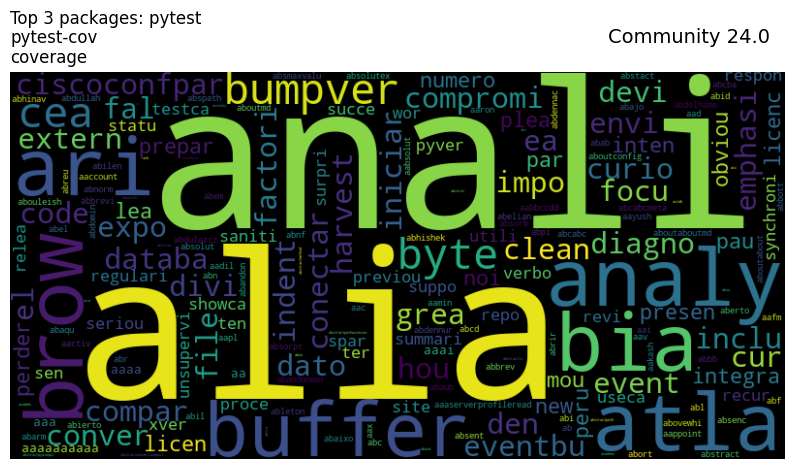

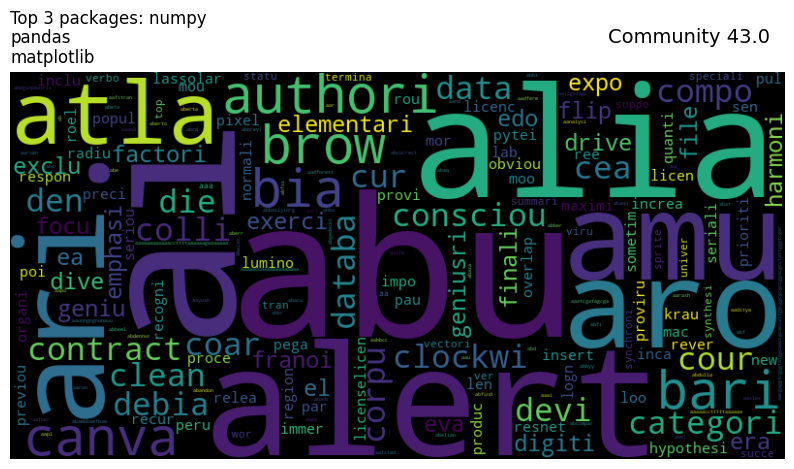

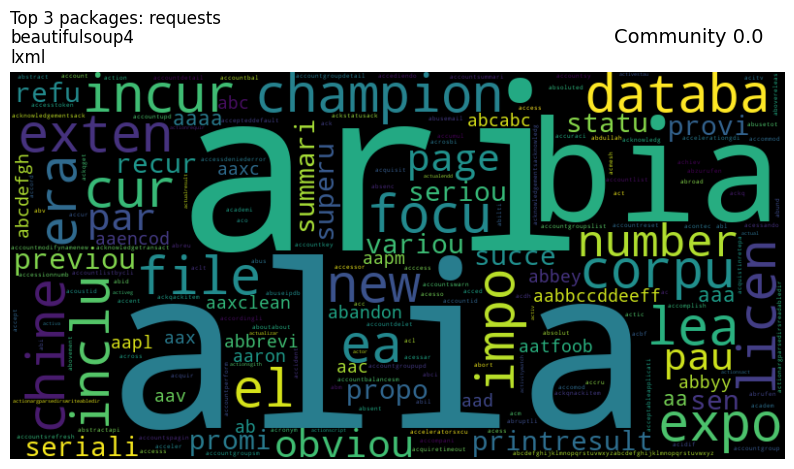

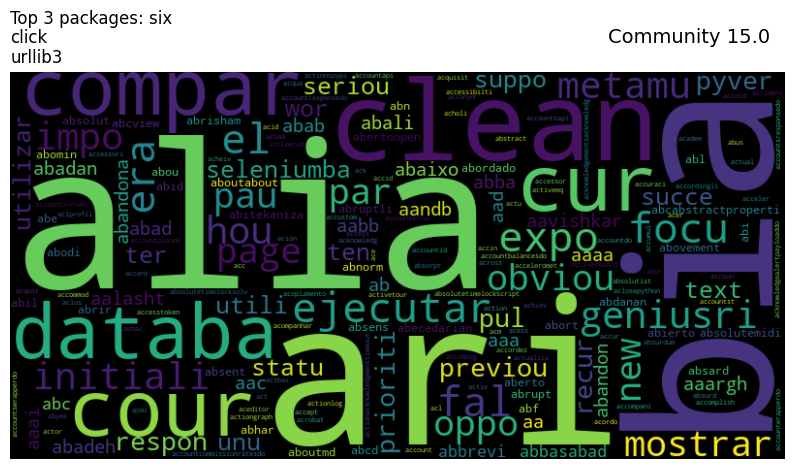

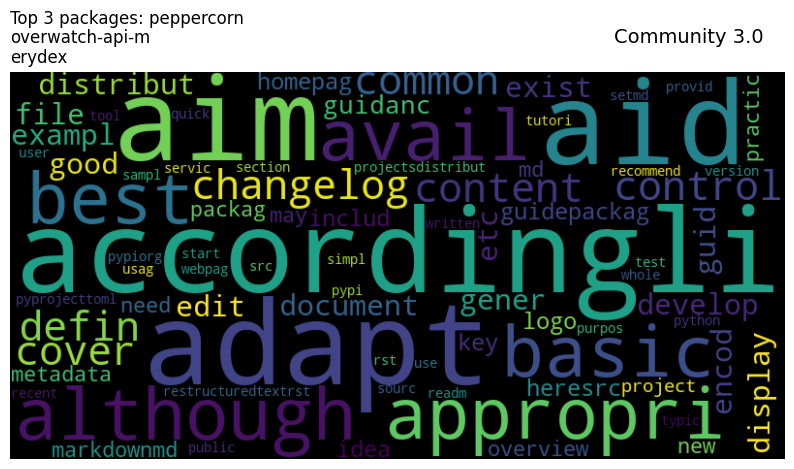

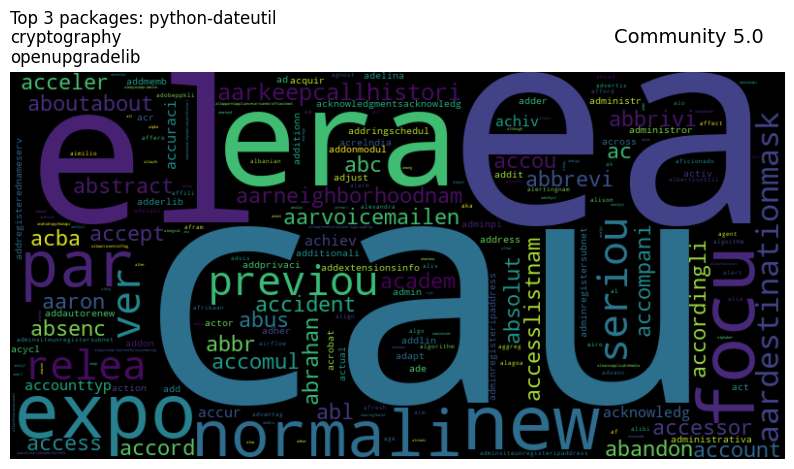

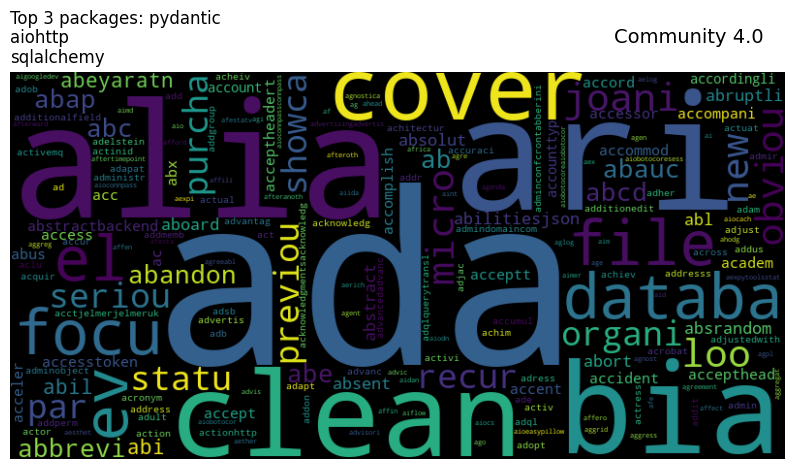

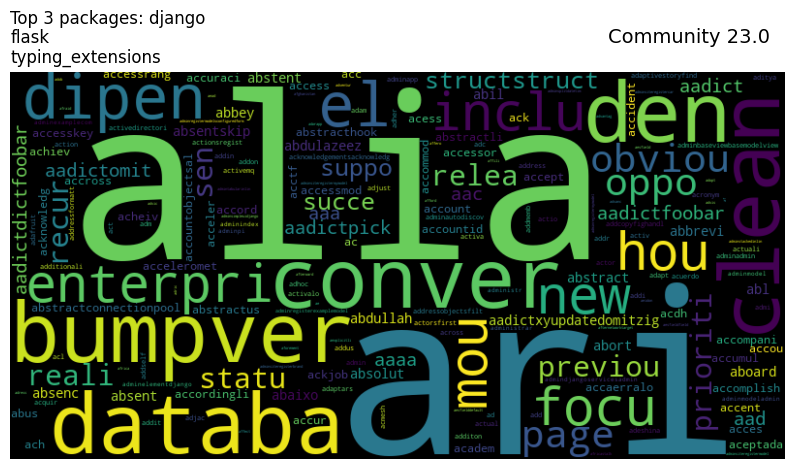

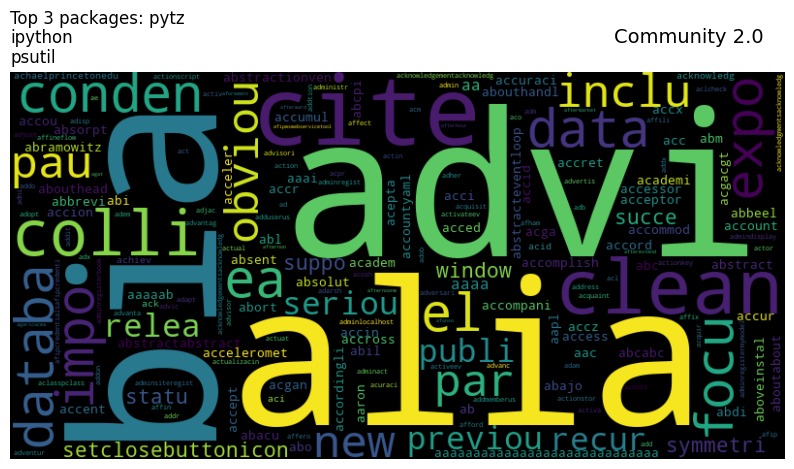

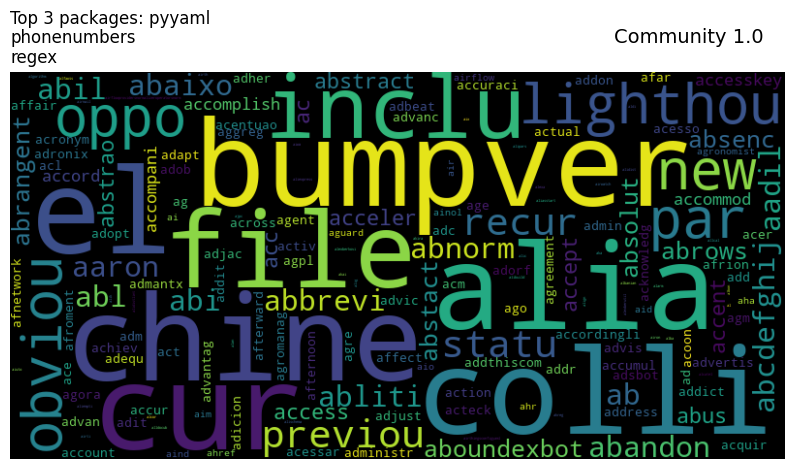

In [55]:
# Create a wordcloud with the information on the communities:
for community in top_10_communities:
    terms = top_10_community_terms[community]
    text = ' '.join(terms)
    wordcloud = wc.WordCloud(width=800, height=400).generate(text)

    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.text(700, -30, f'Community {community}', fontsize=14, color='black', ha='center')
    
    plt.text(0, -50, f'Top 3 packages: {top_3_packages[community][0]}', fontsize=12, color='black', zorder=1)
    plt.text(0, -30, f'{top_3_packages[community][1]}', fontsize=12, color='black', zorder=2)
    plt.text(0, -10, f'{top_3_packages[community][2]}', fontsize=12, color='black', zorder=3)
    
    plt.savefig(f'{image_folder}Community_{community}.png', bbox_inches='tight')
    plt.show()